In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

print(torch.cuda.is_available())

True


# Normalizing Flows

Normalizing flows are generative models which allow you to sample from arbitrary distributions, such as distributions of images. They also let you calculate the probability of a sample, which is useful in various applications such as reinforcement learning. In contrast, Variational Autoencoders only give a lower bound on the probability of a sample.

Normaling flows learn a function which can be applied to a simpler "prior" distrubution (e.g. standard gaussian) to transform variables to the desired distribution. They also learn the inverse of the function which transforms the desired destribution to the simpler prior. In either case, it becomes trivial to sample from the desired distribution by sampling from the simple prior and applying the learned function.

# Background 

## Functions of 1D Random Variables

Suppose $X$ is a 1D random variable with cumulative distribution $F_X$ and probability density function $p_X(x)=\frac{dF_X(x)}{dx}$. Then for $g(\cdot)$ invertible (and therefore monotone) $Y=g(X)$ has density,

$$p_Y(y)=p_X(h(y))|h'(y)|=p_X(x)|h'(y)|$$

For $g^{-1}(\cdot)=h(\cdot)$. 



Proof:

For $h(\cdot)$ monotone increasing, 

$$P(Y\leq y)=P(g(X)\leq y)=P(X\leq h(y))=F_X(h(y))$$

Taking the derivative and using the chain rule,

$$p_Y(y)=p_X(h(y))h'(y)$$

For $h(\cdot)$ monotone decreasing,

$$P(Y\leq y)=P(g(X)\leq y)=P(X\geq h(x))=1-F_X(h(x))$$

By the chain rule,

$$p_Y(y)=-p_X(h(y))h'(y)$$

Therefore,

$$p_Y(y)=p_X(h(y))|h'(y)|$$

## Iterated Transformations

We can iterate this process. Let $Y_1=g_1(X)$ and $g_1^{-1}(\cdot)=h_1(\cdot)$ and $Y_2=g_1(Y_1)$ and $g_2^{-1}(\cdot)=h_2(\cdot)$.

Then,

$$p_{Y_1}(y_1)=p_X(x)h_1'(y_1)$$

and 

$$p_{Y_2}(y_2)=p_{Y_1}(x)h_2'(y_2)=p_X(x)h_2'(y_2)h_1'(y_1)$$

In general, for $Y_i=g_1(g_2(...g_i(X)))$ and $Y=Y_k$ and $g_i^{-1}=h_i$ we have,

$$p_Y(h_K(h_{K-1}...h_1(x)))=p_X(x)\prod_{i=1}^K h_i'(y_i)$$


## Inverse Transform Sampling

We also have that $F_X(X)\sim U(0,1)$ and for $U\sim U(0,1)$ we have $F_X^{-1}(U)$ has cdf $F_X$.

Proof:

Note that cdfs and quantile functions are increasing functions. Also note that $F_X$ has range $[0,1]$ and $F_X^{-1}$ has domain $[0,1]$. Then for $x\in[0,1]$,

$$P(F_X(X)\leq x)=P(X\leq F_X^{-1}(x))=F_X(F^{_1}(x))=x$$

which is the cdf of $U(0,1)$. Also for $u\in\mathbb R$,

$$P(F_X^{-1}(U)\leq u)=P(U\leq F_X(u))=F_X(u)$$

which is the cdf of a random variable with cdf $F_X$.

## Example
Suppose $Z\sim N(0,1)$. Then for $\Phi(\cdot)$ being the cdf of the standard normal distribution, $\Phi(Z)\sim U(0,1)$. Additionally given an arbitrary quantile function $H: \mathbb R\rightarrow[0,1]$, and $G=H^{-1}$, we have $H(\Phi(Z))$ has cdf $G(\cdot)$ and probability density function $\frac{dG(x)}{dx}=g(x)$.

Suppose $g(x)=\frac{3}{8}x^2$ for $x\in[0,2]$ which is increasing on that interval. Then $G(x)=\frac{1}{8}x^3$ and $H(x)=(8x)^{1/3}$. 

Normalizing flows amount to learning an approximation to the function $H(\Phi(\cdot))$ (or equivalently its inverse), which maps samples from the prior (in this case standard normal distribution) to desired distribution $G$ (or equivalently the reverse). They do so by approximating $H(\Phi(\cdot))$ with (possibly stacked) invertible functions which will be elaborated on later.

The transformations described above are illustrated below:

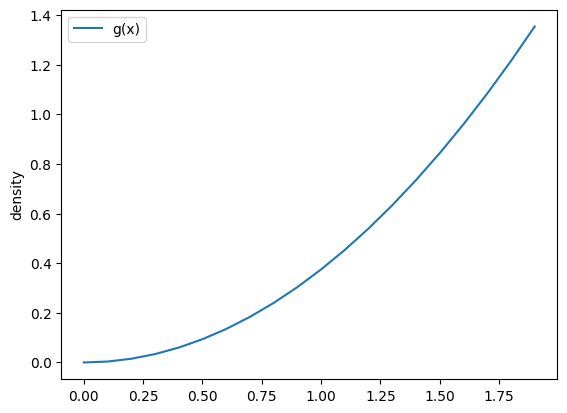

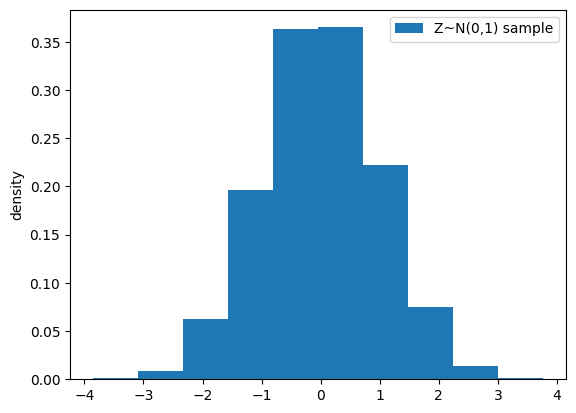

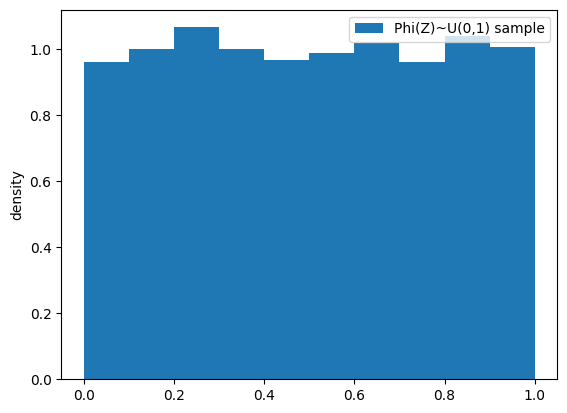

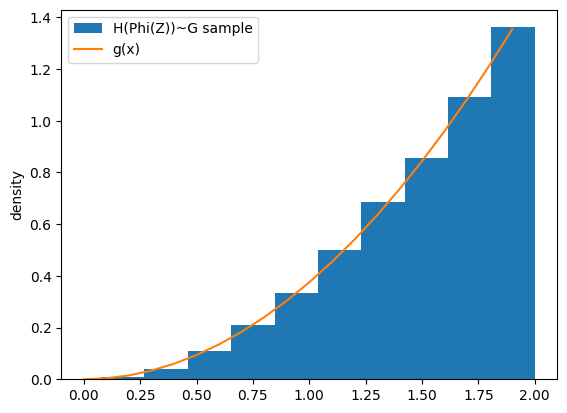

In [66]:


def g(x):
    return 3*x**2/8

plt.plot(np.arange(0,2,0.1),g(np.arange(0,2,0.1)),label="g(x)")
plt.ylabel("density")
plt.legend()
plt.show()


def G(x, inverse=False):
    if not inverse:
        return x**3/8
    else:
        return (8*x)**(1/3)

n = 10000
Z = norm.rvs(size=n)

plt.hist(Z,label="Z~N(0,1) sample",density=True)
plt.ylabel("density")
plt.legend()
plt.show()

Phi_Z = norm.cdf(Z)
plt.hist(Phi_Z,label="Phi(Z)~U(0,1) sample",density=True)
plt.ylabel("density")
plt.legend()
plt.show()

H_Phi_Z = G(Phi_Z,inverse=True)
plt.hist(H_Phi_Z,label="H(Phi(Z))~G sample",density=True)
plt.plot(np.arange(0,2,0.1),g(np.arange(0,2,0.1)),label="g(x)")
plt.ylabel("density")
plt.legend()
plt.show()



# Learning The Transforming Function (1D)

Recall that for $g(\cdot)$ invertible (and therefore monotone) $Y=g(X)$ has density,

$$p_Y(y)=p_X(h(y))|h'(y)|$$

For $g^{-1}(\cdot)=h(\cdot)$. 

Note we also have

$$p_X(x)=p_Y(g(x))|g'(x)|$$


Suppose we have samples of $y$ and we apply $h(\cdot)$ to these samples. If $h(y)=x$ has high likelihood, then $y$ will have high likelihood as well. In practice we maximize,

$$\log(p_Y(y))=\log(p_X(x))+\log(h'(y))$$

With multiple functions we have,

$$\log(p_Y(y))=\log(p_X(x))+\sum_{i=1}^K \log(h_i'(y_i))$$

Another scenario is if we already have $p_Y(y)$, then we can maximize, 

$$\log(p_X(x))=\log(p_Y(y))+\log(g'(x))$$

I'll illustrate learning through both these methods later on.

## A suitable 1D approximator
A simple method to approximate 1D functions is with a strictly increasing, piecewise linear function. We represent such a function by defining K points, between which points are interpolated and positive slopes for any points occuring before or after. Additionally to ensure the function is strictly increasing, and invertible, we define the K x-coordinates as constants that $x_1<x_2<...<x_K$, $y_1$ as a learnable paramater, and $\delta_2,...,\delta_K$ such that $y_2=y_1+\exp(\delta_2),y_3=y_2+\exp(\delta_2),...,y_K=y_{K-1}+\exp(\delta_K)$. A similar choice could be performed for the x-coordinates but for simplicity we leave that aside. 

Additionally due to being linear, it is very simple to compute $\log h'(y)$ as just the log of the slopes of the line segment at $y$.

This is implemented below.

Testing IncreasingPieceWiseLinear1D


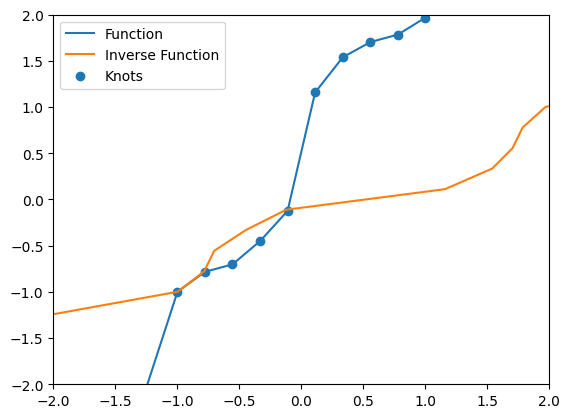

In [47]:
class IncreasingPieceWiseLinear1D(nn.Module):
    def __init__(self, x_coords):
        """
        x_coords: sorted list/1D tensor of shape (K,)
                  Must satisfy x_1 < x_2 < ... < x_K
        """
        super().__init__()
        self.register_buffer("x_coords", torch.tensor(x_coords, dtype=torch.float32))

        K = len(x_coords)
        # Learnable y_1
        self.y1 = nn.Parameter(torch.tensor(x_coords[0]))
        # Learnable deltas for y_2...y_K (K-1 values)
        # to start such that slopes are approximate 1, (y2-y1)/(x2-x1)~1, y2-y1=exp(incr2), incr2~log(x2-x1)
        self.delta = nn.Parameter(torch.randn(K - 1)+self.x_coords.diff().log())
        self.log_slope_start = nn.Parameter(torch.randn(1))
        self.log_slope_end = nn.Parameter(torch.randn(1))

    def forward(self, x,inverse=False):
        """
        Evaluate the monotonic piecewise linear function at x.
        x: tensor of shape (...,)
        """
        # Compute y-coordinates ensuring monotonicity
        increments = torch.exp(self.delta)
        y_coords = torch.cat([self.y1.unsqueeze(0),increments]).cumsum(dim=0)
        slope_values = y_coords.diff()/self.x_coords.diff()
        slope_values = torch.cat([torch.exp(self.log_slope_start),
                                  slope_values,
                                  torch.exp(self.log_slope_end)
                                  ])
        if not inverse:
            # Linear interpolation
            # Find which segment each x falls into
            idx = torch.bucketize(x, self.x_coords)
            slopes = slope_values[idx]
            x0 = self.x_coords[torch.clamp(idx-1,min=0)]
            y0 = y_coords[torch.clamp(idx-1,min=0)]
            return y0+slopes*(x-x0),torch.log(slopes)
        else:
            y = x
            slope_values = 1/slope_values
            idx = torch.bucketize(y, y_coords)
            slopes = slope_values[idx]
            x0 = self.x_coords[torch.clamp(idx-1,min=0)]
            y0 = y_coords[torch.clamp(idx-1,min=0)]
            return x0+slopes*(y-y0),torch.log(slopes)
        

print("Testing IncreasingPieceWiseLinear1D")

x_coords = np.linspace(-1,1,10)
pw1 = IncreasingPieceWiseLinear1D(x_coords)

k=2
x = torch.linspace(-k,k,1000)
with torch.no_grad():
    plt.plot(x.numpy(), pw1.forward(x)[0].numpy(),label="Function")
    plt.plot(x.numpy(), pw1.forward(x,True)[0].numpy(),label="Inverse Function")
    plt.scatter(x_coords, pw1.forward(torch.tensor(x_coords))[0].numpy(),label="Knots")
    
plt.xlim(-k,k)
plt.ylim(-k,k)
plt.legend()
plt.show()


## 1D Normalizing Flow

We're ready to create a normalizing flow model! It should use one or multiple invertible functions each of whose gradient we know to transform $x$ to $y$ and also the reverse.

In [48]:
from torch.distributions import Normal

class Flow1D(nn.Module):
    def __init__(self,n_layers):
        super().__init__()
        self.net = nn.ModuleList([IncreasingPieceWiseLinear1D(np.linspace(-4,4,30)) for _ in range(n_layers)])
        self.prior = Normal(0,1)

    def forward(self,x,inverse=False):
        if inverse:
            net = reversed(self.net)
        else:
            net = self.net

        log_grad = x.new_zeros(x.shape[0])
        for layer in net:
            x, log_grad_i = layer(x,inverse=inverse) 
            log_grad+=log_grad_i
       
        return x, log_grad

    def log_p_x(self, x):
        x, log_grad = self.forward(x)
        return self.prior.log_prob(x)+log_grad

    def log_p_z(self, x, log_p_x):
        _, log_grad = self.forward(x,inverse=True)
        return log_p_x+log_grad

    
    def sample(self,n=1):
        z = self.prior.sample((n,))
        x,_ = self.forward(z,inverse=True)
        return x

# Training

To train, we just draw from the desired sample. In our case, that's the distribution, but if we were in higher dimensions and drawing images, that would just be drawing images. Recall that we can sample from our distribution  by applying the inverse cdf of it to uniform random variables. To confirm it worked, we just compare the transformation the neural network learns to the analytical transformation.

In [58]:
flow = Flow1D(1)
optimizer = optim.Adam(flow.parameters(),lr=1e-4)

def sample(n):
    return G(np.random.uniform(size=n),inverse=True)

for i in range(30001):
    loss = -flow.log_p_x(torch.tensor(sample(100))).mean() # negative to maximize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%1000==0:
        print(f"{i}:",loss.item())
    


0: 23.212838838036213
1000: 16.40677675245498
2000: 11.646179242501962
3000: 8.30647004293709
4000: 6.188615368047848
5000: 4.57079349145335
6000: 3.15591077637387
7000: 2.1996203155522136
8000: 1.565346413513955
9000: 1.1073884594232397
10000: 0.9296567689346782
11000: 0.7234766036642096
12000: 0.5966491428196805
13000: 0.6324987032810646
14000: 0.5838062774066887
15000: 0.4767068542348651
16000: 0.5541205527563177
17000: 0.36592704913609597
18000: 0.43636616498247205
19000: 0.3710309075333306
20000: 0.2508427007449033
21000: 0.34333709848893335
22000: 0.42629024323583775
23000: 0.4165441760266301
24000: 0.4003303379585796
25000: 0.35471644682206416
26000: 0.4395011388905874
27000: 0.25844156125242185
28000: 0.3463126847690961
29000: 0.28824527686510754
30000: 0.41293733450688125


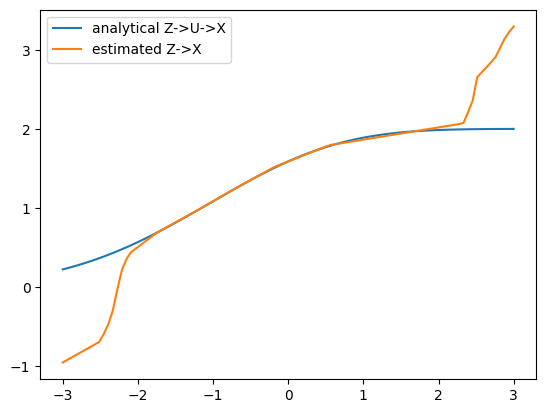

In [67]:
x = np.linspace(-3,3,100)
plt.plot(x,G(norm.cdf(x),inverse=True),label="analytical Z->U->X")
plt.plot(x,flow.forward(torch.tensor(x),inverse=True)[0].detach().numpy(),label="estimated Z->X")
plt.legend()
plt.show()

We can also compare samples

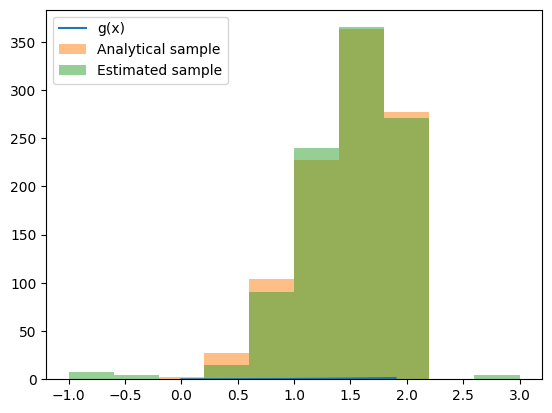

In [ ]:

plt.plot(np.arange(0,2,0.1),g(np.arange(0,2,0.1)),label="g(x)")
plt.hist(sample(1000),label="Analytical sample",range=(-1,3),alpha=0.5,density=True)
plt.hist(flow.sample(1000).detach().numpy(),label="Estimated sample",range=(-1,3),alpha=0.5,density=True)
plt.legend()
plt.show()


